# Distributional word representations

Much of this taken from Christopher Potts' CS224u course from Spring 2016.

In [1]:
__version__ = "DS-GA 1012, NYU, Spring 2019"

## Overview

In this exercise and assignment, we want to explore creating vector representations of words (__distributed representations__) from co-occurence patterns in text.

Note that the term __embedding__, __word vector__, or __word embedding__ can also be used for distributed representations.

## Set-up

In [1]:
from collections import defaultdict
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Distributional matrices

Here's a basic recipe for building a word $\times$ word matrix:
    
0. Define a notion of co-occurrence context. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.
0. Scan through your corpus building a dictionary $d$ mapping word-pairs to counts. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1),  increment $d[(w, w')]$ by $1$.
0. Using the count dictionary $d$ that you collected in 2, establish your full vocabulary $V$, an ordered list of words types. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. You might impose a minimum count threshold even if $|V|$ is small &mdash; for words with very low counts, you simply don't have enough evidence to say anything interesting.
0. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the count $d[(w_i, w_j)]$.

For different designs, the procedure differs slightly. For example, if you are building a word $\times$ document matrix, then the rows of $M$ represent words and the columns of $M$ represent documents. The scan in step 2 then just keeps track of (_word_, _document_) pairs &mdash; compiling the number of times that _word_ appears in _document_. Such matrices are often used in information retrieval, because the columns are multi-set representations of documents. They are much sparser than the the word $\times$ word matrices we will work with here. (In my experience, they yield lower-quality lexicons, but others have reported good results with them.)

Let's practice building a co-occurrence matrix. We'll use data from the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/). Download the main zip and extract the file `datasetSentences.txt`.

In [3]:
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data

We want to build a co-occurrence matrix where words are considered co-oocurring if they are adjacent in a sentence. Let's implement this function.

Some practical notes:
- for the project, it's okay to use outside libraries, but it's good practice to implement things from scratch
- try to stick to built-in Python data structures as much as possible, as using library data structures can add bloat and slow things down. Building the co-occurrence matrix should generally be pretty fast as it only requires one pass over the data, except instantiating the full matrix may be somewhat slow.

In [ ]:
def build_cooccurrence_matrix():
    raise NotImplementedError

In [7]:
data_file = 'stanfordSentimentTreebank/datasetSentences.txt'

data = load_sst(data_file)
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000)

Counting words...
	Finished counting words in 0.31881
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 33.60083


We now have distributed, distributional word representations! Each row of this co-occurrence matrix can be seen as a word vector, nice!

## Vector comparison

A key operation on word vectors is being able to compare them. For the most part, we are interested in measuring the _distance_ between vectors. We surmise that semantically related words should be close together and semantically unrelated words should be far apart in the vector spaces we build.

### Euclidean distance

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is 

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$ 

In two-dimensions, this corresponds to the length of the most direct line between the two points.

As part of the exercise, implement this without using any other packages beyond what has been imported already.

In [41]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    raise NotImplementedError

Here's a tiny vector space:

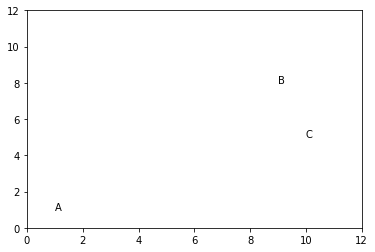

In [9]:
ABC = np.array([
    [ 1.0,  1.0],  # A
    [9.0, 8.0],  # B
    [10.0, 5.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

The euclidean distances align well with the raw visual distance in the plot:

In [10]:
euclidean(ABC[0], ABC[1])

10.63014581273465

In [11]:
euclidean(ABC[1], ABC[2])

3.1622776601683795

### Length normalization

Suppose we believed that vector B should be closer to vector A than to vector C. The Euclidean distances do not reflect that relationship.

One strategy to impose this relationship is to normalize the vectors. We might normalize each vector by its __length__, which is defined for a vector $u$ of dimension $n$ as 

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$ 

Please fill in `vector_length` below:

In [50]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    raise NotImplementedError

Let's use our function to write a length-normalizing function.

In [13]:
def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u)

Normalization changes the affinity or distance between points A, B, and C dramatically. Is normalization the right thing to do?

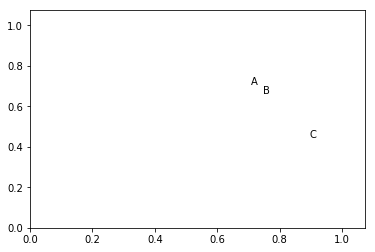

In [14]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

Implicitly, we have replaced Euclidean distance as our distance metric with cosine distance. __Cosine distance__ takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is 

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the _angles_ between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using `vector_length` and then calculating their Euclidean distance.

Implement this below:

In [55]:
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    raise NotImplementedError

### Other distance measures

It is very common to use Euclidean and cosine distance, but there are other distance measures one might consider using. For example, the particular definition of length we used is the L2-norm (because of the $^2$ exponent); we might consider using a different exponent such as $^1$, yielding the L1-norm.

As practice, let's consider the Jaccard distance, which is defined as 

$$ J(u, v) = 1 - \left( \frac{\sum_{i} min(u_i, v_i)}{\sum_{i} max(u_i, v_i) } \right) $$

Jaccard distance measures how dissimilar two vectors are by comparing their "intersection" and "union" (it's usually defined in context of sets). Let's implement this:

In [ ]:
def jaccard(u, v):
    """Jaccard similarity between two real-valued vectors"""
    raise NotImplementedError

A recent line of work is in learning _hyperbolic_ word embeddings, where the embeddings live in a non-Euclidean, hyperbolic space. The appeal of this approach is that the learned embeddings can respect the hierarchical relationship that some words have with each other.

For more information, see [Nickel and Kiela (2017)](https://arxiv.org/abs/1705.08039) or [Chamberlain et al. (2017)](https://arxiv.org/abs/1705.10359).

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [17]:
for m in (euclidean, cosine, jaccard):
    fmt = {'n': m.__name__,  
           'AB': m(ABC[0], ABC[1]), 
           'BC': m(ABC[1], ABC[2])}
    print('%(n)15s(A, B) = %(AB)5.3f %(n)15s(B, C) = %(BC)5.3f' % fmt)

      euclidean(A, B) = 10.630       euclidean(B, C) = 3.162
         cosine(A, B) = 0.002          cosine(B, C) = 0.034
        jaccard(A, B) = 0.882         jaccard(B, C) = 0.222


## Distributional neighbors

The `neighbors` function is an investigative aide. For a given `word`, it ranks all the words in the vocabulary `rownames` according to their distance from `word`, as measured by `distfunc` in matrix `mat`:

In [66]:
def neighbors(tok, mat, tok2idx, idx2tok, distfunc=cosine):    
    """Tool for finding the nearest neighbors of `word` in `mat` according 
    to `distfunc`. The comparisons are between row vectors.
    
    Parameters
    ----------
    tok : str
        The anchor word. Assumed to be in `tok2idx`.
        
    mat : np.array
        The vector-space model.
        
    tok2idx : list of str
        The rownames of mat.
            
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure  
        between 1d vectors.
    
    Returns
    -------    
    list of tuples
        The list is ordered by closeness to `word`. Each member is a pair 
        (word, distance) where word is a str and distance is a float.
    
    """
    raise NotImplementedError

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example calls; you might try some new words to get a feel for what these matrices are like and how different words look.

In [19]:
neighbors(tok='superb', mat=mat, tok2idx=tok2idx, idx2tok=idx2tok, distfunc=euclidean)[: 10]

[('superb', 0.0),
 ('cipher', 4.69041575982343),
 ('illuminated', 4.69041575982343),
 ('Using', 4.795831523312719),
 ('spine', 4.795831523312719),
 ('legend', 4.898979485566356),
 ('shining', 4.898979485566356),
 ('lick', 4.898979485566356),
 ('bravura', 4.898979485566356),
 ('stellar', 4.898979485566356)]

In [20]:
neighbors(tok='superb', mat=mat, tok2idx=tok2idx, idx2tok=idx2tok, distfunc=cosine)[: 10]

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


[('superb', 1.1102230246251565e-16),
 ('cipher', 0.5219085562662426),
 ('fellow', 0.5271337562565397),
 ('illuminated', 0.527544408738466),
 ('terrific', 0.5281792278953805),
 ('solid', 0.538018447402505),
 ('wonderful', 0.5496408554571595),
 ('fault', 0.5552504100033393),
 ('good', 0.560877926872458),
 ('Using', 0.5635642195280153)]

These rankings are okay, with `cosine` less likely to associate words that happen to have similar frequency, but somewhat noisy. 

## Matrix reweighting

Reweighting aims to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. The intuition behind moving away from raw counts is that just using frequency is too fuzzy a concept for our goal of encoding semantics.

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With [length_norm](#Length-normalization), we normalize using `vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

In [29]:
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])

In [30]:
norm_mat = rowwise_norm_mat(mat)

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Key point: These normalization measures are insensitive to the _magnitude_ of the underlying counts. 

This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different in ways that will be partly or totally obscured by normalization.

How do we solve this? Pointwise mutual information (see homework)!

## Dimensionality reduction

The above methods deliver solid results. However, they are not capable of capturing higher-order associations in the data. For example, both _gnarly_ and _wicked_ are used as slangily positive adjectives. We thus expect them to have many of the same neighbors. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely 
to occur often in the same texts. Dimensionality reduction techniques are often capable of capturing their semantic similarity (and have the added advantage of shrinking the size of our data structures).

The general goal of dimensionality reduction is to eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart. __Latent Semantic Analysis__ (LSA) is a prominent method. It is an application of truncated __singular value decomposition__ (SVD). SVD is a central matrix operation; 'truncation' here means looking only at submatrices of the full decomposition. LSA seeks not only to find a reduced-sized matrix but also to capture similarities that come not just from direct co-occurrence, but also from second-order co-occurrence.

Dimensionality reduction is also particularly helpful in our case because our vectors are very sparse. Intuitively, many words don't often appear right next to each other, so many entries in the word vectors are zero. By reducing our word vectors, we won't need to pass around very large vectors and remove some of the sparsity.

In [61]:
def lsa(mat=None, k=100):
    """Latent Semantic Analysis using pure scipy.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
        
    k : int (default: 100)
        Number of dimensions to truncate to.
        
    Returns
    -------    
    (np.array, list of str)
        The first member is the SVD-reduced version of `mat` with 
        dimension (m x k), where m is the rowcount of mat and `k` is 
        either the user-supplied k or the column count of `mat`, whichever 
        is smaller. The second member is `rownames` (unchanged).

    """    
    raise NotImplementedError

Here's a look at the following example:

In [23]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_idx2tok = {0:'gnarly', 1:'wicked', 2:'awesome', 3:'lame', 4:'terrible'}
gn_tok2idx = {v: k for k, v in gn_idx2tok.items()}

In [24]:
neighbors(tok='gnarly', mat=gnmat, tok2idx=gn_tok2idx, idx2tok=gn_idx2tok, distfunc=cosine)

[('gnarly', 2.220446049250313e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

We see that _gnarly_ and _wicked_ are not close to each other. (Well, it's a small space, but they are as close as _gnarly_ and _lame_.) Reweighting by PMI, PPMI, or TF-IDF is no help. LSA to the rescue:

In [25]:
gnmat_lsa = lsa(mat=gnmat, k=2)

In [26]:
neighbors(tok='gnarly', mat=gnmat_lsa, tok2idx=gn_tok2idx, idx2tok=gn_idx2tok, distfunc=cosine)

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

## Evaluation: Word Similarity

We've done a good deal of work creating these word vectors, but how do we know how good they are? Inspecting the neighbors of words according to their vectors and making sure they match our intuition is a good hueristic.

Expanding on this idea, we can evaluate the quality of word vectors by using them to compute similarities of pairs of words and then comparing those similarities to human judgments. Let's use this strategy to evaluate the word vectors we just learned. We'll use the [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) word similarity dataset.

In [31]:
def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

In [ ]:
from scipy.stats import spearmanr

def evaluate_word_similarity():
    raise NotImplementedError

In [34]:
test_file = 'MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file)

In [49]:
evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)

Evaluated on 248 of 771 examples


0.02485435870523964

## Bonus

Our word vectors aren't very good (NLP isn't that easy...). There are some great pre-computed matrices available online too. These aren't matrices of counts, but rather more abstract values computed using methods like those under discussion here. [GloVe](https://nlp.stanford.edu/projects/glove/) is a unsupervised learning algorithm that learns vector representations of words using word-to-word cooccurence matrices from a corpus. 

Write code to load the GloVe vectors (you don't necessarily need to load *all* of them) and evaluate them on MTurk-771. To receive the ~*bonus*~ (0.2 points on your overall grade), show your code to the instructor and the value when evaluating the first 50,000 GloVe word vectors on MTurk-771 (ignoring OOV examples).